# The Horse-race Model of Bet-hedging

In this notebook we will use betting on a horse race as a model for the bet-hedging strategy in changing environments. Remember, the idea of bet-hedging is that, if the environment switches randomly between multiple conditions, the population may diversify into coexisting groups of individuals that exhibit different phenotypes, each being favorable for a particular environment. We can map this description onto a horse race as follows. At each round, the environment corresponds to which horse will actually win the race, and the phenotypes are different choices of horses to bet on. A bet-hedging strategy means distributing money over multiple choices. The odds (the reward for every dollar you bet if you win) are then analogous to the number of offspring produced by each invididual in a given environment, and the rate of capital gain is analogous to the population growth rate.

What is special about the horse race is that, if money is bet on the wrong horse, there is no return. That means only one phenotype can survive in each environmental condition. This assumption simplifies the mathematics and allows us to study the situation where the distribution of phenotypes can depend on external signals. For example, some bacterial species have type-I persister cells, which are induced by environmental triggers such as lack of nutrients. We will see that when such information is used to adjust the phenotype distribution optimally, the population's longterm growth rate can be further increased. This would correspond to the situation in a horse race where we have secret information about the race to help us place bets on the horses.

## Betting with no information

Let us simulate the random process of betting on the horse race. We can reuse the `BetHedging` class defined for studying persister cells before.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BetHedging:
    """
    simulate bet-hedging strategy in changing environments.
    """
    
    def __init__(self, phe_dist, fit_mat, N0=1., record=True):
        """
        initialize population.
        inputs:
        phe_dist: 1-d array-like, phenotype distribution q[i] (should sum to 1).
        fit_mat: 2-d array-like, fitness matrix f[i,j] = number of offspring for phenotype i in environment j.
        N0: real, initial population size (use real instead of integer).
        record: bool, whether to record history of environment and population size.
        """
        self.phe_dist = np.asarray(phe_dist)    # phenotype distribution q_i
        self.fit_mat = np.asarray(fit_mat)    # fitness matrix f_{ij}
        self.pop_size = float(N0)    # current population size
        self.time = 0    # current number of generations since the beginning of simulation
        self.record = record
        if record:
            self.env_hist = []
            self.pop_hist = []
    
    def grow(self, env_seq):
        """
        simulation population growth in changing environments.
        inputs:
        env_seq: 1-d array-like, environment sequence, list of environment indices.
        """
        T = len(env_seq)
        for t in range(T):
            env = env_seq[t]    # environmental condition at each time step
            factor = np.dot(self.phe_dist, self.fit_mat[:,env])    # growth factor according to formula
            new_pop = self.pop_size * factor    # new population size at next time step
            if self.record:    # record history
                self.env_hist.append(env)
                self.pop_hist.append(self.pop_size)
            self.pop_size = new_pop    # update population size

### Asset growth

We first need to specify the odds. This can be represented by a "fitness matrix" as follows:
\begin{equation}
\mathbf{f} = \left( \begin{matrix} R_0 & 0 \\ 0 & R_1 \end{matrix} \right)
\end{equation}
where $R_0$ and $R_1$ are the returns if horse #0 or #1 wins. Note that the matrix is diagonal because there is no return for betting on the wrong horse.

In [3]:
fit_mat = np.array([[1.3, 0.0],
                    [0.0, 4.5]])

Now we have to decide on a strategy, i.e., allocation of money to bet on each horse. Since the second horse has a *higher* return, we might expect it to have a *smaller* chance of winning. So let us try putting *less* money on it.

In [4]:
phe_dist = [0.7, 0.3]

To simulate the outcomes of repeated races, we will generate a random sequence representing which horse wins at every round.

In [5]:
env_dist = [0.77, 0.23]    # true probability of each horse winning
T = 10000    # number of rounds
env_seq = np.random.choice(2, size=T, p=env_dist)    # index of horse to win at each round

Let us pretend that we do not know the true probabilities, and use our chosen strategy to bet on the horses. We can make a simulation of the capital growth using the `BetHedging` class.

In [6]:
bh1 = BetHedging(phe_dist, fit_mat)
bh1.grow(env_seq)

To see how well we are doing, let us plot our money versus time.

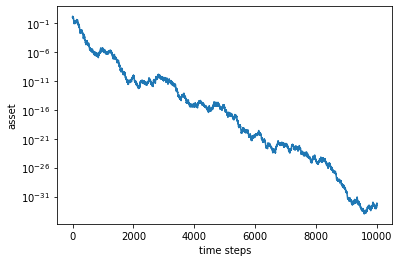

In [7]:
plt.figure()
plt.plot(bh1.pop_hist)
plt.yscale('log')
plt.xlabel('time steps')
plt.ylabel('asset')
plt.show()

This looks rather "unfortunate"... Nevertheless, let us calculate the average growth rate over a long time $T$:
\begin{equation}
\Lambda = \frac{1}{T} \, \log \frac{N_T}{N_0}
\end{equation}

average growth rate = -0.0074115639989703495


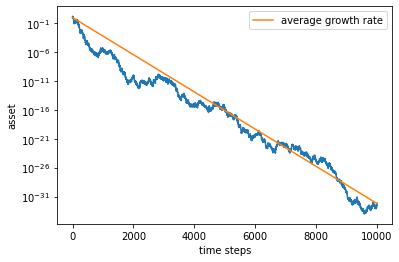

In [8]:
T = len(bh1.pop_hist)
lam_avg = np.log(bh1.pop_hist[T-1] / bh1.pop_hist[0]) / T
print(f'average growth rate = {lam_avg}')

plt.figure()
plt.plot(bh1.pop_hist)
plt.plot(bh1.pop_hist[0] * np.exp(lam_avg * np.arange(T)), label='average growth rate')
plt.yscale('log')
plt.xlabel('time steps')
plt.ylabel('asset')
plt.legend()
plt.show()

The capital growth rate is negative -- no wonder that we are losing money!

### Optimal bet

To figure out the optimal betting strategy, let us try different distributions and repeat the steps above.

In [9]:
q1_list = np.linspace(0, 1, 101)    # list of phenotype distribution element q_1
lam_avg_list = []    # list to collect average growth rates

for q1 in q1_list:
    phe_dist = [1-q1, q1]
    bh1 = BetHedging(phe_dist, fit_mat)
    bh1.grow(env_seq)
    lam_avg = np.log(bh1.pop_hist[T-1]) / T
    lam_avg_list.append(lam_avg)

/home/b.xue/Programs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


We can plot the average growth rate with respect to the bets to see which strategy works best.

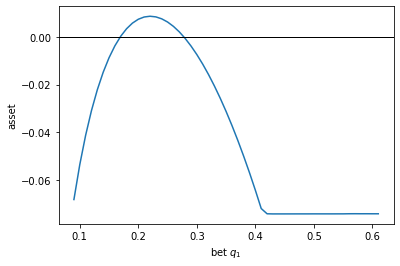

In [10]:
plt.figure()
plt.plot(q1_list, lam_avg_list)
plt.axhline(0, color='k', lw=1)
plt.xlabel(r'bet $q_1$')
plt.ylabel('asset')
plt.show()

It appears that only a narrow window between around $q_1 = 0.18$ and $0.28$ would give a positive growth rate. (Don't worry about the flat part of the curve on the right -- it is because we ran into round-off error there.)

We can find the optimal bet by looking for the maximum growth rate.

In [11]:
imax = np.argmax(lam_avg_list)    # returns index of maximum value
q1_opt = q1_list[imax]    # find value of q1 at that index
lam_max = lam_avg_list[imax]    # maximum growth rate
print(f'optimal bet = {[1-q1_opt, q1_opt]}')
print(f'maximum growth rate = {lam_max}')

optimal bet = [0.78, 0.22]
maximum growth rate = 0.008624615881219351


The bets we chose were not that far off. However, the odds are so tight that there is only a small window where one could make money.

Mathematically, when the fitness matrix is diagonal, we expect the optimal phenotype distribution to be equal to the environment distribution. In this case, the true environment distribution used to generate the random sequence was (0.77, 0.23). The optimal bet is indeed close to it (the small difference is because the empirical distribution of the finite environment sequence is in fact (0.7796, 0.2204)).

## Betting with side information

For a set of "unbiased" odds, e.g., $R_i = 1/p_i$, where $p_i$ are the true probabilities of each horse winning, the best one can do is not losing money, because the maximum growth rate will be zero. To prove that, recall from the lecture that, theoretically,
\begin{equation}
\Lambda = \sum_i p_i \log (q_i R_i)
\end{equation}
In the unbiased case, we have:
\begin{equation}
\Lambda = \sum_i p_i \log (q_i / p_i) = -D(p \Vert q) \leq 0
\end{equation}
where $D(p \Vert q)$ is the *relative entropy* between the probability distributions $p$ and $q$, which is non-negative.

So how can we possibly make money? The trick is, to get insider's information! That is, we want to receive a secret message (or so-called "side information"), which is hopefully correlated with the actual outcome of the race. For example, we may receive word that "horse 0 will win", and, while it may not be completely reliable, it may indicate that horse 0 has an advantage that is known to the insider. In that case, we might want to adjust our strategy to put *more* money on horse 0 (but not necessarily *all* the money because the message could be wrong).

To model side information, let us denote the message by $\eta$, which can take a value $\eta = i$ that means "horse $i$ should win". Since we will base our bets on this information, we will use a *conditional* probability distribution $q(j|i)$. That means, given a message $\eta = i$, we will bet a fraction $q(j|i)$ of our money on horse $j$. For two horses, our strategy then becomes a (2x2) matrix, instead of a 2-d vector. Since the probabilities should sum to 1 for any given message, i.e., $\sum_j q(j|i) = 1$ for all $i$, we can parametrize the matrix by:
\begin{equation}
q(j|i) = \left( \begin{matrix} 1 - q_{10} & 1 - q_{11} \\ q_{10} & q_{11} \end{matrix} \right)
\end{equation}
That is, each column should sum to 1. At every round, we will receive a message, and will choose the money distribution given the message. Therefore, our asset grows by a factor:
\begin{equation}
N_{t+1} = N_t \, \sum_\phi q(\phi|\eta_t) f(\phi;\varepsilon_t)
\end{equation}
where $f(\phi;\varepsilon)$ is a general fitness matrix like before, and $\varepsilon_t$ and $\eta_t$ are the environment and message received at that round.

Let us write a python class to simulate bet-hedging using side information. Besides the environment sequence, we will also have a message sequence as input to the `grow` method.

In [12]:
class BetHedgingWithSideInformation(BetHedging):
    """
    simulate bet-hedging with side information.
    note that here `self.phe_dist` should be a 2-d array representing a conditional distribution q(j|i).
    """
    
    def grow(self, env_seq, mes_seq):    # decorating base method
        """
        simulation population growth in changing environments.
        inputs:
        env_seq: 1-d array-like, environment sequence, list of environment indices.
        mes_seq: 1-d array-like, message sequence, list of message indices.
        """
        T = len(env_seq)
        for t in range(T):
            env = env_seq[t]    # environmental condition at each time step
            mes = mes_seq[t]    # message at each time step
            factor = np.dot(self.phe_dist[:,mes], self.fit_mat[:,env])    # growth factor
            new_pop = self.pop_size * factor    # new population size at next time step
            if self.record:    # record history
                self.env_hist.append(env)
                self.pop_hist.append(self.pop_size)
            self.pop_size = new_pop    # update population size

Now let us create a message sequence that is somewhat correlated with the environment sequence but not completely. For example, we can make the message correct for 80% of the time.

In [13]:
mes_seq = []
for env in env_seq:
    if env == 0:
        mes = np.random.choice(2, p=(0.8, 0.2))
    elif env == 1:
        mes = np.random.choice(2, p=(0.2, 0.8))
    mes_seq.append(mes)

Let us see how well we can do with such side information. Suppose we choose to believe the message with only 70% confidence, i.e., if the message says "horse 0", we bet 70% of our money on horse 0, and vice versa. Then our conditional distribution is:

In [14]:
phe_dist2 = np.array([[0.7, 0.3],
                      [0.3, 0.7]])

We can simulate our asset growth as follows.

In [15]:
bh2 = BetHedgingWithSideInformation(phe_dist2, fit_mat)
bh2.grow(env_seq, mes_seq)

average growth rate = 0.01114425914350944


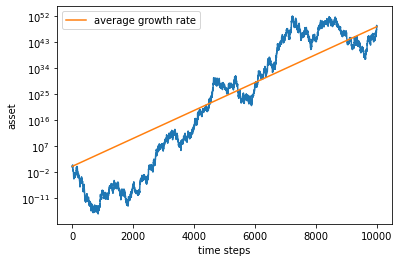

In [16]:
T = len(bh2.pop_hist)
lam_avg2 = np.log(bh2.pop_hist[T-1]) / T
print(f'average growth rate = {lam_avg2}')

plt.figure()
plt.plot(bh2.pop_hist)
plt.plot(np.exp(lam_avg2 * np.arange(T)), label='average growth rate')
plt.yscale('log')
plt.xlabel('time steps')
plt.ylabel('asset')
plt.legend()
plt.show()

Hooray! We are now making money.

### Optimal bet with side information

How do we make the best use of the side information? That is, what would be the optimal betting strategy given the side information? To find it out, let us try different strategies by varying the parameters $q_{10}$ and $q_{11}$. Note that we will use the same environment and message sequences for all simulations, so that the growth rate will be a smooth function of the parameters.

In [17]:
q10_list = np.linspace(0, 1, 101)    # list of q_10 values
q11_list = np.linspace(0, 1, 101)    # list of q_11 values
lam_avg_array = np.zeros((len(q10_list), len(q11_list)))

for i in range(len(q10_list)):
    for j in range(len(q11_list)):
        q10 = q10_list[i]
        q11 = q11_list[j]
        phe_dist = np.array([[1-q10, 1-q11],
                             [q10,   q11]])
        bh2 = BetHedgingWithSideInformation(phe_dist, fit_mat)
        T = 2000    # use a shorter time to avoid round-off and save time
        bh2.grow(env_seq[:T], mes_seq[:T])
        lam_avg = np.log(bh2.pop_hist[T-1]) / T
        lam_avg_array[i,j] = lam_avg
        print(f'q10 = {q10:.2f}, q11 = {q11:.2f}, lam_avg = {lam_avg:.6f}', end='\r')

/home/b.xue/Programs/python/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Since it is a 2-d array, we can plot our result as a heatmap.

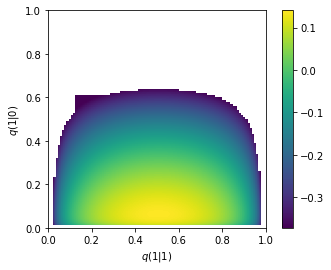

In [18]:
plt.figure()
plt.imshow(lam_avg_array, extent=(0, 1, 0, 1), origin='lower')
plt.colorbar()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$q(1|1)$')
plt.ylabel(r'$q(1|0)$')
plt.show()

We can see the parameter region where the growth rate peaks (don't worry about some regions that are cut out because of round-off error). Let us find the values of the distribution with the maximum growth rate.

In [19]:
imax, jmax = np.unravel_index(np.argmax(lam_avg_array), lam_avg_array.shape)
q10_opt = q10_list[imax]
q11_opt = q11_list[jmax]
lam_avg_max = lam_avg_array[imax, jmax]
print(f'optimal conditional bets =\n{np.array([[1-q10_opt, 1-q11_opt], [q10_opt, q11_opt]])}')
print(f'maximum growth rate = {lam_avg_max}')

optimal conditional bets =
[[0.94 0.49]
 [0.06 0.51]]
maximum growth rate = 0.14081738596108814


According to this optimal conditional strategy, we should not fully trust the message (indeed, recall that the message is accurate only 80% of the time). For example, when we receive message "1", we should only bet about half of the money on each horse. Intuitively, this is because horse 1 has a relatively low chance of winning, so even when we are told that it is going to win, we should take that with a grain of salt and be more cautious.

To see how we are using the side information, we should compare to the best strategy without side information, which we found above to be (0.78, 0.22). That means, when we receive a message "0", we increase the bet on horse 0 from 78% to 94%; similarly, when we receive a message "1", we increase the bet on horse 1 from 22% to 51%. As a result, we have increased our asset growth rate from 0.01 to 0.14 --- this is the value of side information.